In [ ]:
# Summary

In [ ]:
# Tutorial Overview

In [1]:
#Import Libraries
import numpy as np  
import pandas as pd  
import pandas_datareader as web  
from scipy.stats import norm
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline

from quandl_config import QUANDL_API_KEY # file with my personal Quandl Key

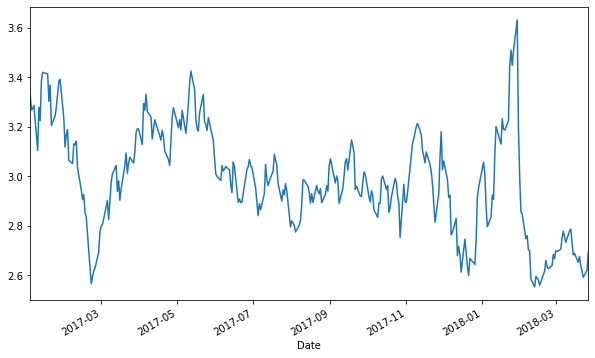

In [2]:
# Settings for Monte Carlo asset data, how long, and how many forecasts 
ticker = 'CHRIS/CME_NG1' # Natural Gas (Henry Hub) Physical Futures, Continuous Contract #1 (NG1) (Front Month)
t_intervals = 30 # time steps forecasted into future
iterations = 25 # amount of simulations

start_date = datetime.datetime(2017, 1, 3)
end_date = datetime.datetime(2018, 3, 27)
pred_end_date = datetime.datetime(2019, 10, 3)

df = web.DataReader(ticker, 'quandl', start_date, end_date, api_key = QUANDL_API_KEY)['Settle'] # Some tickers use 'Close' instead of 'Settle'

#Plot of asset historical closing price
df.plot(figsize=(10, 6))

In [3]:
forecast_dates = [d if d.isoweekday() in range(1, 6) else np.nan for d in pd.date_range(end_date, pred_end_date)] 
intervals = len(forecast_dates)

def mc_returns(df: pd.DataFrame = df, t_intervals: int = 30, iterations: int = 20)-> list:
    #Preparing log returns from data
    log_returns = np.log(1 + df.pct_change())

    #Setting up drift and random component in relation to asset data
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

    #Takes last data point as startpoint point for simulation
    S0 = df.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0
    #Applies Monte Carlo simulation in asset
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]

    forecast_df = pd.DataFrame(price_list, index = forecast_dates)
    
    return forecast_df

def mc_plot(lst: list)-> plt:
    #Plot simulations
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plot(forecast_df)

(array([ 33.,  70.,  52.,  35.,  56.,  91., 107.,  74.,  32.,   6.]),
 array([3.04085711, 3.32367432, 3.60649152, 3.88930873, 4.17212594,
        4.45494314, 4.73776035, 5.02057756, 5.30339476, 5.58621197,
        5.86902918]),
 <a list of 10 Patch objects>)

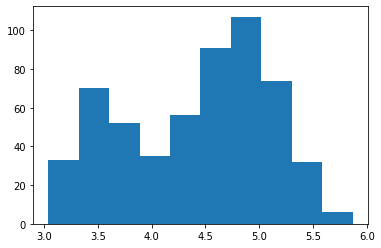

In [4]:
forecast_df = mc_returns(df, t_intervals = intervals)
end_values = forecast_df.iloc[:,-1].values
plt.hist(end_values)


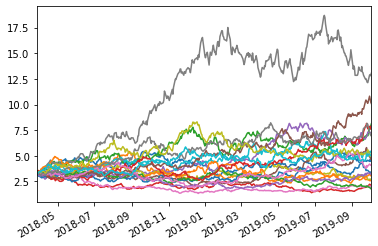

In [7]:
forecast_df.plot(legend=False)

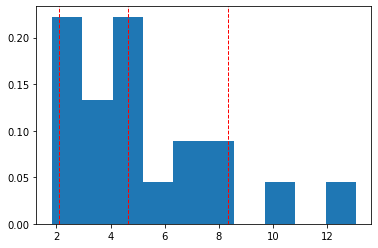

In [15]:
#mcs = run_mcs()
end_values = forecast_df.values[-1]
plt.hist(end_values,density=True)

a_lines = [.1, .5, .9]
for line in a_lines:
    plt.axvline(np.quantile(end_values, line), color='r', linestyle='dashed', linewidth=1)
plt.show()

<Figure size 720x432 with 0 Axes>

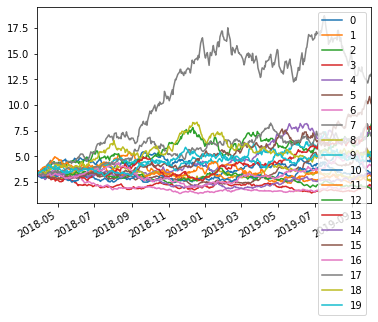

In [20]:
plt.figure(figsize=(10,6))
#plt.plot(df)
forecast_df.plot()

In [28]:
vals = forecast_df.values
dates = forecast_df.index

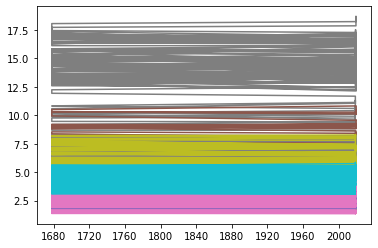

In [33]:
plt.plot(dates, vals)

In [390]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import math
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab


from quandl_config import QUANDL_API_KEY # file with my personal Quandl Key

  
class MonteCarlo:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
    def get_asset(self, symbol):
        #Dates
        start = self.start 
        end = self.end 
        
        prices = web.DataReader(symbol, 'quandl', start, end, api_key = QUANDL_API_KEY)['Close']
        returns = prices.pct_change()
        
        self.returns = returns
        self.prices = prices
        
    def get_portfolio(self, symbols, weights):
        start = self.start
        end = self.end
        
        #Get Price Data
        df = web.DataReader(symbol, 'quandl', start, end, api_key = QUANDL_API_KEY)['Close']
        #Percent Change
        returns = df.pct_change()
        returns += 1
        
        #Define dollar amount in each asset
        port_val = returns * weights
        port_val['Portfolio Value'] = port_val.sum(axis=1)
        
        #Portfolio Dollar Values
        prices = port_val['Portfolio Value']
        
        #Portfolio Returns
        returns = port_val['Portfolio Value'].pct_change()
        returns = returns.replace([np.inf, -np.inf], np.nan)
                
        self.returns = returns
        self.prices = prices
        
    def monte_carlo_sim(self, num_simulations, predicted_days):
        returns = self.returns
        prices = self.prices
        
        last_price = prices[-1]
        
        simulation_df = pd.DataFrame()

        #Create Each Simulation as a Column in df
        for index, x in enumerate(range(num_simulations)):
            daily_vol = returns.std()
            
            price_series = []
            
            #Append Start Value
            price = last_price * (1 + np.random.normal(0, daily_vol))
            price_series.append(price)
            
            #Series for Preditcted Days
            for i in range(predicted_days, 252):
                price = price_series[index] * (1 + np.random.normal(0, daily_vol))
                price_series.append(price)
        
            simulation_df[x] = price_series
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days

    def brownian_motion(self, num_simulations, predicted_days):
        returns = self.returns
        prices = self.prices

        last_price = prices[-1]

        #Note we are assuming drift here
        simulation_df = pd.DataFrame()
        
        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            
            #Inputs
            count = 0
            avg_daily_ret = returns.mean()
            variance = returns.var()
            
            daily_vol = returns.std()
            daily_drift = avg_daily_ret - (variance/2)
            drift = daily_drift - 0.5 * daily_vol ** 2
            
            #Append Start Value    
            prices = []

            prices.append(last_price)
            
            for i in range(predicted_days, 252):

                shock = drift + daily_vol * np.random.normal()
                price = prices[count] * np.exp(shock)
                prices.append(price)
        
                count += 1
            simulation_df[x] = prices
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days

    def line_graph(self):
        prices = self.prices
        predicted_days = self.predicted_days
        simulation_df = self.simulation_df
        
        last_price = prices[-1]
        fig = plt.figure()
        
        title = "Monte Carlo Simulation: {} days".format(predicted_days)
        plt.plot(simulation_df, color = 'r', alpha = .25)
        fig.suptitle(title,fontsize=18, fontweight='bold')
        plt.xlabel('Day')
        plt.ylabel('Price ($)')
        plt.grid(True,color='grey')
        plt.axhline(y=last_price, color='b', linestyle='-')
        plt.show()

    def histogram(self):
        simulation_df = self.simulation_df
        
        ser = simulation_df.iloc[-1, :]
        
        num_bins = 20
        # the histogram of the data
        n, bins, patches = plt.hist(ser, num_bins, normed=1, facecolor='blue', alpha=0.5)
         
        # add a 'best fit' line
        
        plt.plot(bins, stats.norm.pdf(ser), 'r--')
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
        plt.show()

    def VaR(self):
        simulation_df = self.simulation_df
        prices = self.prices

        last_price = prices[-1]
        
        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int)  
        var =  np.percentile(price_array, 1)
        
        val_at_risk = last_price - var
        print("Value at Risk: {}".format(val_at_risk))
        
        #Histogram
        fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
        plt.plot(price_array, fit, '-')
        plt.hist(price_array, density=True, color = 'r', alpha = .25)
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
        plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: {:.2f}'.format(var))
        plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: {:.2f}'.format(last_price))
        plt.legend(loc="upper right")
        plt.show()

    def key_stats(self):
        simulation_df = self.simulation_df
        
        print('#------------------Simulation Stats------------------#')
        
        for index, column in enumerate(simulation_df):
            print ("Simulation {} Mean Price: \t {:.2f}".format(index, simulation_df[column].mean()))
            print ("Simulation {} Median Price: \t {:.2f}".format(index, simulation_df[column].median()))
        
        print('\n #----------------------Last Price Stats--------------------#')
        print("Mean Price: \t {:.2f}".format(np.mean(simulation_df.iloc[-1,:])))
        print("Maximum Price: \t {:.2f}".format(simulation_df.iloc[-1,:].max()))
        print("Minimum Price: \t {:.2f}".format(simulation_df.iloc[-1,:].min()))
        print("St. Deviation: \t {:.2f}".format(simulation_df.iloc[-1,:].std()))
       
        print('\n #----------------------Descriptive Stats-------------------#')
        print(simulation_df.iloc[-1, :].describe().round(decimals=2))
               
        print('\n #--------------Annual Expected Returns for Trials-----------#')
        future_returns = simulation_df.pct_change()
        for index, column in enumerate(future_returns):
            print ("Simulation {} Annual Expected Return \t {:.2f}".format(index, (future_returns[column].mean() * 252) * 100))
            print ("Simulation {} Total Return \t {:.2f}".format(index, (future_returns[column].iloc[1] / future_returns[column].iloc[-1] - 1) * 100))
        
        print('\n #----------------------Percentiles--------------------------------#')
        percentile_list = [.25, .50, .75]
        for per in percentile_list:
            print ("{:.0f}th Percentile: \t {:.2f}".format(per*100, simulation_df.iloc[-1,:].quantile(per)))
        
        print('\n #-----------------Calculate Probabilities-------------------------#')
        # print ("Probability price is between 30 and 40: {:.2f}".format(8/13))
        # print ("Probability price is less than 45: {:.2f}".format(2/5))
        
if __name__== "__main__":

    start = datetime.datetime(2017, 1, 3)
    end = datetime.datetime(2019, 10, 4)
    
    sim = monte_carlo(start, end)

    #symbols = ['AAPL', 'KO', 'HD', 'PM']
    #weights = [1000,1000,2000,3000]
    
    #sim.get_portfolio(symbols, weights)
    sim.get_asset('WIKI/GOOG')

    sim.brownian_motion(10, 20)
    #sim.line_graph()
    #sim.VaR()
    sim.key_stats()

#------------------Simulation Stats------------------#
Simulation 0 Mean Price: 	 839.39
Simulation 0 Median Price: 	 845.87
Simulation 1 Mean Price: 	 740.63
Simulation 1 Median Price: 	 733.90
Simulation 2 Mean Price: 	 736.41
Simulation 2 Median Price: 	 730.92
Simulation 3 Mean Price: 	 672.37
Simulation 3 Median Price: 	 668.27
Simulation 4 Mean Price: 	 613.43
Simulation 4 Median Price: 	 564.22
Simulation 5 Mean Price: 	 609.68
Simulation 5 Median Price: 	 592.30
Simulation 6 Mean Price: 	 614.79
Simulation 6 Median Price: 	 589.96
Simulation 7 Mean Price: 	 787.72
Simulation 7 Median Price: 	 788.20
Simulation 8 Mean Price: 	 731.01
Simulation 8 Median Price: 	 748.83
Simulation 9 Mean Price: 	 616.72
Simulation 9 Median Price: 	 580.13

 #----------------------Last Price Stats--------------------#
Mean Price: 	 632.14
Maximum Price: 	 794.85
Minimum Price: 	 490.50
St. Deviation: 	 119.07

 #----------------------Descriptive Stats-------------------#
count     10.00
mean     6

In [27]:
forecast_df.dropna(inplace=True)

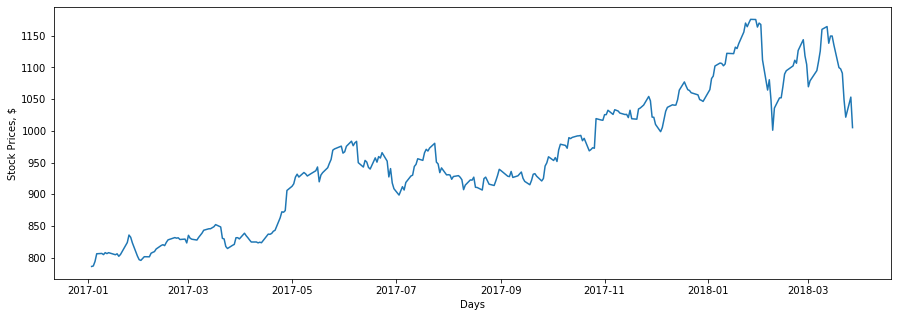

TypeError: cannot do index indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [693] of <class 'int'>

In [18]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

stock_name = 'WIKI/GOOG'

start_date = datetime.datetime(2017, 1, 3)
end_date = datetime.datetime(2018, 3, 27)
pred_end_date = datetime.datetime(2019, 10, 3)

prices = quandl.get(stock_name, 
                authtoken=QUANDL_API_KEY, 
                start_date =start_date, end_date = end_date
                ).reset_index(drop = False)[['Date', 'Close']]

prices.set_index('Date', inplace = True)
plt.figure(figsize = (15, 5))
plt.plot(prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, $')
plt.show()

#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

def gbm(**kwargs):

    mc_get_data()
    mc_para_assignments()
    mc_drift()
    mc_preds()
    mc_plot()
    return 

start_date = datetime.datetime(2017, 1, 3)
end_date = datetime.datetime(2018, 3, 27)
pred_end_date = datetime.datetime(2019, 10, 3)

def mc_get_data(verbose = False):
    date_range = pd.date_range(start = end_date, 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna()

    # We get daily closing stock prices of E.ON for July 2019
    df = quandl.get(stock_name, 
                   authtoken=QUANDL_API_KEY, 
                   start_date = start_date, end_date = end_date
                   ).reset_index(drop = False)[['Date', 'Close']]

    returns = (df.loc[1:, 'Close'] - df.shift(1).loc[1:, 'Close']) / df.shift(1).loc[1:, 'Close']
    
    if verbose:
        print(df.head())
        print(df.tail())
        print(returns.tolist())
    
    return date_range, df, returns


def mc_para_assignments():
    # Parameter Assignments
    """
    : So    :   initial stock price
    : dt    :   time increment -> a day in our case
    : T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
    : N     :   number of time points in prediction the time horizon -> T/dt
    : t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
    : mu    :   mean of historical daily returns
    : sigma :   standard deviation of historical daily returns
    : b     :   array for brownian increments
    : W     :   array for brownian path
    """
    So = df.loc[df.shape[0] - 1, "Close"]
    dt = 1 # day   # User input
    n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
    T = n_of_wkdays # days  # User input -> follows from pred_end_date
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = len(date_range)
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    return So, df, mu, sigma, b, W

def mc_drift(verbose = False):
    # Calculating drift and diffusion components
    
    drift = (mu - 0.5 * sigma**2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    if verbose:
        print(drift)
        print(diffusion)

    return drift, diffusion

def mc_preds(verbose = False):
    # Making the predictions
    
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
    if verbose:
        print(S)
    return S

def mc_plot(joint = False):
    # Plotting the simulations

    plt.figure(figsize = (20,10))
    if joint:
        plt.plot(prices['Close'])
    for i in range(scen_size):
        plt.title("Daily Volatility: {:.4f}".format(sigma))
        plt.plot(date_range, S[i, :], c = 'r', alpha = .25)
        plt.ylabel('Stock Prices, $')
        plt.xlabel('Prediction Days')
        plt.hlines(y = prices['Close'][-1:], xmin=end_date, xmax=pred_end_date, label = "Last Observed Price", color="black")
    plt.show()


def make_preds_df(size = 10):
    # Dataframe format for predictions - first 10 scenarios only
    Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :size]).set_index(
               pd.date_range(start = df["Date"].max(), 
               end = pred_end_date, freq = 'D').map(lambda x:
               x if x.isoweekday() in range(1, 6) else np.nan).dropna()
               )

if __name__== "__main__":
    gbm()

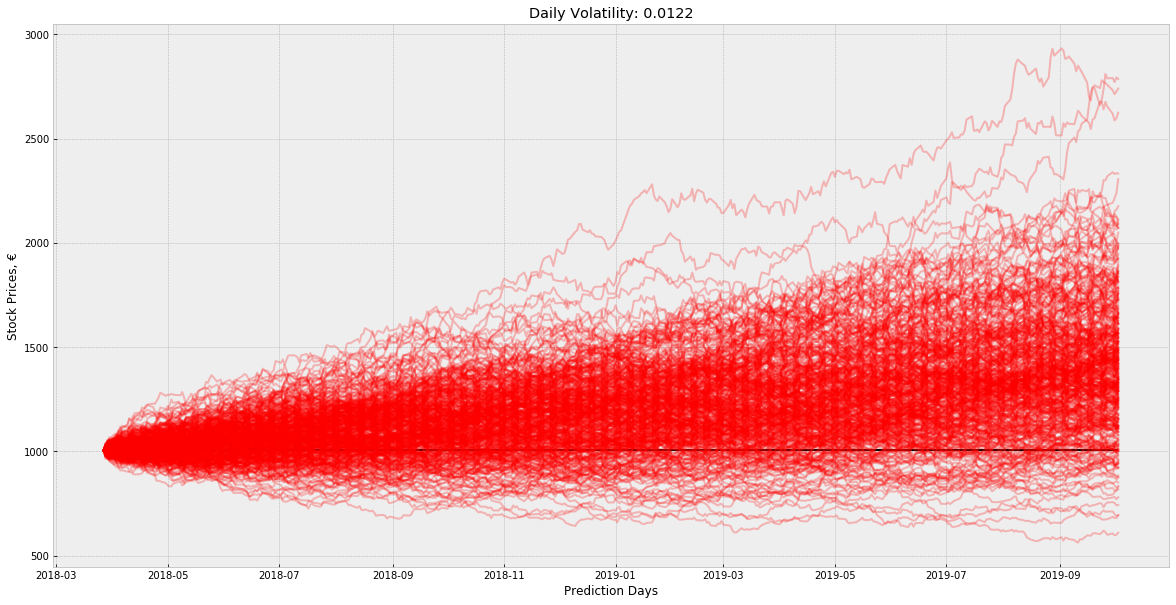

In [254]:
gbm(verbose = True)

In [281]:
def mc_VaR():
    simulation_df = df1
    prices = prices

    last_price = prices[-1]

    price_array = simulation_df.iloc[-1, :]
    price_array = sorted(price_array, key=int)  
    var =  np.percentile(price_array, 1)

    val_at_risk = last_price - var
    print("Value at Risk: {}".format(val_at_risk))

    #Histogram
    fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
    plt.plot(price_array, fit, '-')
    plt.hist(price_array, density=True, color = 'r', alpha = .25)
    plt.xlabel('Price')
    plt.ylabel('Probability')
    plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
    plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: {:.2f}'.format(var))
    plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: {:.2f}'.format(last_price))
    plt.legend(loc="upper right")
    plt.show()

In [270]:
def mc_hist():
    #Histogram
    fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
    #plt.plot(price_array, fit, '-')
    plt.hist(price_array, density=True, color = 'r', alpha = .25)
    plt.xlabel('Price')
    plt.ylabel('Probability')
    plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
    #plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: {:.2f}'.format(var))
    #plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: {:.2f}'.format(last_price))
    plt.legend(loc="upper right")
    plt.show()
    
    
def mc_plot(joint = False):
    # Plotting the simulations

    plt.figure(figsize = (20,10))
    if joint:
        plt.plot(prices['Close'])
    for i in range(scen_size):
        plt.title("Daily Volatility: {:.4f}".format(sigma))
        plt.plot(date_range, S[i, :], c = 'r', alpha = .25)
        plt.ylabel('Stock Prices, $')
        plt.xlabel('Prediction Days')
        plt.hlines(y = prices['Close'][-1:], xmin=end_date, xmax=pred_end_date, label = "Last Observed Price", color="black")
    plt.show()
    
price_array = df1.iloc[:,-1].values

def mc_hist():
    #Histogram
    fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
    plt.plot(price_array, fit, '-')
    plt.hist(price_array, density=True, color = 'r', alpha = .25)
    plt.xlabel('Price')
    plt.ylabel('Probability')
    plt.title('Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
    plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: {:.2f}'.format(var))
    plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: {:.2f}'.format(last_price))
    plt.legend(loc="upper right")
    plt.show()

def histogram():  
    ser = S[:,-1]
        
    num_bins = 20
    plt.hist(ser, num_bins, density=1, facecolor='blue', alpha=0.5)
         
    plt.xlabel('Price')
    plt.ylabel('Probability')
    plt.title('Histogram of Speculated Stock Prices')

    return plt.show()

def histogram():
        
        ser = df1.iloc[:,-1].values
        
        num_bins = 20
        n, bins, patches = plt.hist(ser, num_bins, normed=1, facecolor='blue', alpha=0.5)
         
        # add a 'best fit' line
        plt.plot(bins, stats.norm.pdf(ser), 'r--')
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
        plt.show()
        
def histogram():  
    ser = S[:,-1]
        
    num_bins = 20
    plt.hist(ser, num_bins, density=1, facecolor='blue', alpha=0.5)
         
    plt.xlabel('Price')
    plt.ylabel('Probability')
    plt.title('Histogram of Speculated Stock Prices')

    return plt.show()


# histogram
df['Returns'].hist(bins = 20, density=True)
"""x = np.linspace(stats.norm.ppf(0.01), stats.norm.ppf(0.99), 100)
plt.plot(x, stats.norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')"""
mu = df['Returns'].mean()
sigma = df['Returns'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

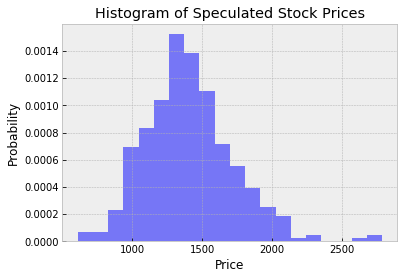

In [361]:
histogram()

In [424]:
VaR_90 = stats.norm.pdf(1-.9, mu, sigma)

In [425]:
VaR_90

8.454951504542156e-14

In [428]:
df.sort_values('Returns', inplace=True, ascending=True)

In [432]:
df.quantile(.9)

Close      1104.888000
Returns       0.011239
Name: 0.9, dtype: float64

In [435]:
# var.py

import datetime
import numpy as np
import pandas_datareader.data as web
from scipy.stats import norm


def var_cov_var(P, c, mu, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

if __name__ == "__main__":
"""    start = datetime.datetime(2010, 1, 1)
    end = datetime.datetime(2014, 1, 1)"""

    citi = web.DataReader("C", 'yahoo', start, end)
    citi["rets"] = citi["Adj Close"].pct_change()

    P = 1e6   # 1,000,000 USD
    c = 0.99  # 99% confidence interval
    mu = np.mean(citi["rets"])
    sigma = np.std(citi["rets"])

    var = var_cov_var(P, c, mu, sigma)
    print ("Value-at-Risk: $%0.2f" % var)

Value-at-Risk: $56472.60


In [449]:
%time
mean = np.mean(rets_1)
std = np.std(rets_1)
Z_99 = stats.norm.ppf(1-0.99)
price = df.iloc[-1]['Close']
print(mean, std, Z_99, price)

    
ParamVAR = price*Z_99*std
HistVAR = price*np.percentile(rets_1.dropna(), 1)

print('Parametric VAR is {0:.3f} and Historical VAR is {1:.3f}'.format(ParamVAR, HistVAR))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
0.010862372019638992 0.14919055235743953 -2.3263478740408408 1005.1
Parametric VAR is -348.839 and Historical VAR is -265.711


In [23]:
dr = pd.DataFrame(ret, index = forecast_dates)

In [14]:
ret = mc_returns()